### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from fast_style_transfer_utils import *

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Restructure dataset in convenient way

In [8]:
style = 'Picasso.png'
dataset_path = path/f'{style[:-4]}.csv'

if not os.path.isfile(dataset_path):
    print(f'{style[:-4]} dataset does not exist. Creating it...')
    build_style_dataframe(path, style)
    
df = pd.read_csv(dataset_path)
style_img = PIL.Image.open(df.sample().style_.iloc[0]); (style_img.size + (3,))

(863, 486, 3)

In [9]:
df.head()

,content_,style_,split_
0,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train
1,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train
2,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train
3,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train
4,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/Picasso.png,train


### FastStyleTransfer

In [11]:
bs = 4
#sample = 0.5
size = 300
padding = 30

rgb = MakeRGB()
resized = ResizeFixed(size)
tobyte = ToByteTensor()
tofloat = ToFloatTensor()
norm = Normalize(imagenet_stats, padding)
aug = PilRandomDihedral()

tmfs = [rgb, resized, tobyte, tofloat, norm]

train_ds = StyleTransferDataset(dataset_path, train_test='train', transform=tmfs, sample=0.02)
valid_ds = StyleTransferDataset(dataset_path, train_test='valid', transform=tmfs, sample=0.5)

dataloaders = {'train': DataLoader(train_ds, batch_size=bs, shuffle=True),
              'valid': DataLoader(valid_ds, batch_size=bs)}

Valid dataset: 29 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 360, 360]),'content':torch.Size([3, 360, 360]),'style':torch.Size([3, 360, 360])
Train dataset: 1628 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 360, 360]),'content':torch.Size([3, 360, 360]),'style':torch.Size([3, 360, 360])
train 570
shape of re-center-cropped image: (300, 300, 3)


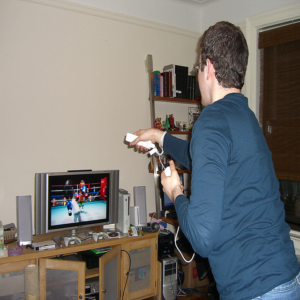

In [13]:
print(valid_ds)
print(train_ds)

datasets = {'train': train_ds, 'valid': valid_ds}
d = random.choice(['train', 'valid'])
i = random.choice(range(len(datasets[d])))
print(d, i)

test_data(dataloaders, datasets, bs, size, padding)
test_deprocess(datasets[d][i], size, padding)

In [4]:
#"block1_conv2"
#"block2_conv2"
#"block3_conv3"
#"block4_conv3"
#"block5_conv3"

In [14]:
test_hooks(TransformerNet(), dataloaders, bs)
test_losses(TransformerNet(), dataloaders)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 80501553.43it/s]


shape of input_act:  [torch.Size([4, 64, 360, 360]), torch.Size([4, 128, 180, 180]), torch.Size([4, 256, 90, 90]), torch.Size([4, 512, 45, 45]), torch.Size([4, 512, 22, 22])]
shape of content_act:  [torch.Size([4, 64, 360, 360]), torch.Size([4, 128, 180, 180]), torch.Size([4, 256, 90, 90]), torch.Size([4, 512, 45, 45]), torch.Size([4, 512, 22, 22])]
shape of style_act:  [torch.Size([4, 64, 360, 360]), torch.Size([4, 128, 180, 180]), torch.Size([4, 256, 90, 90]), torch.Size([4, 512, 45, 45]), torch.Size([4, 512, 22, 22])]


In [6]:
# tv_weight=1, content_weight=1e3, style_weight=1e10 vgg16
# tv_weight=5e-2, content_weight=3e3, style_weight=2e10 vgg16
# tv_weight=2e-1, content_weight=4e3, style_weight=2e10, vgg=19

In [15]:
fst = FastStyleTransfer(dataloaders, *get_model_opt(TransformerNet()), tv_weight=5e-1, content_weight=4e3, style_weight=2e10, vgg=19)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 81633095.46it/s]


In [16]:
fst.train()


Phase: train


batch: 0: (input, content, style) = torch.Size([4, 3, 360, 360]), torch.Size([4, 3, 360, 360]), torch.Size([4, 3, 360, 360])
phase: train, loss: 80404.3882063882

Phase: valid


batch: 0: (input, content, style) = torch.Size([4, 3, 360, 360]), torch.Size([4, 3, 360, 360]), torch.Size([4, 3, 360, 360])
12m 21s



In [17]:
fst.training_done

True

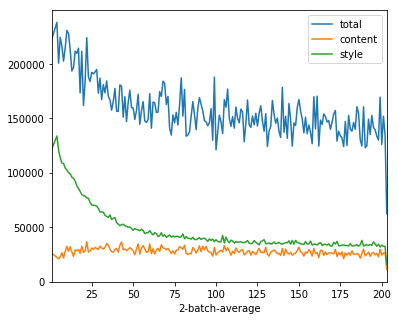

In [18]:
fst.plot_losses('train', group=2)

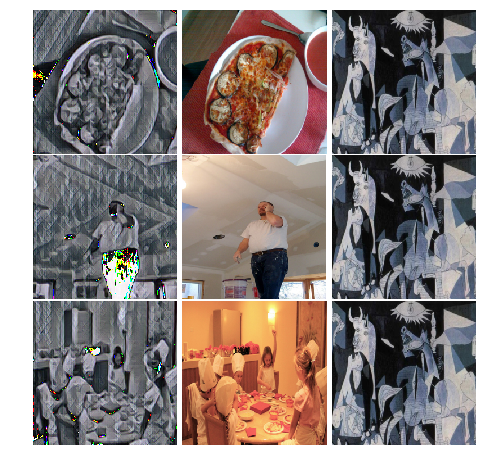

In [19]:
fst.plot_samples('train')

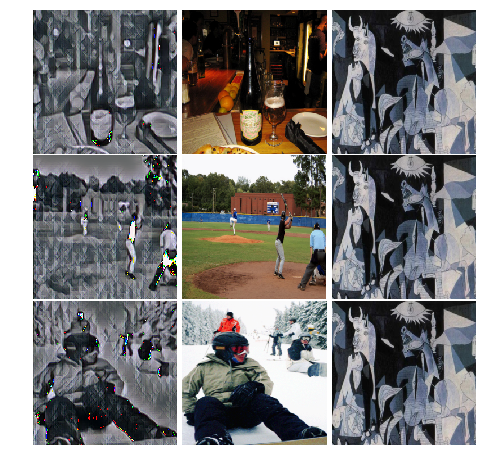

In [20]:
fst.plot_samples('valid')